### IMPORTING DEPENDENCIES

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
import skimage
from skimage.transform import resize
from sklearn.metrics import classification_report
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.utils import load_dataset

# Disabling eager execution from TF 2
tf.compat.v1.disable_eager_execution()

# Increasing Matplotlib font size
matplotlib.rcParams.update({"font.size": 14})

### DATA LOADING

In [6]:
class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
class_names_label = {class_name: i for i, class_name in enumerate(class_names)}

IMAGE_SIZE = (150, 150)

In [7]:
def load_data():
    DIRECTORY = r"C:\dataset"
    CATEGORY = ["train", "test"]
    
    output = []
    
    for category in CATEGORY:
        path = os.path.join(DIRECTORY, category)
        images = []
        labels = []
        
        print("Loading {}".format(category))
        
        for folder in os.listdir(path):
            label = class_names.index(folder)
            
            for file in os.listdir(os.path.join(path, folder)):
                img_path = os.path.join(os.path.join(path, folder), file)
                
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)
                
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')
        
        output.append((images, labels))
        
    return output


In [8]:
(train_images,train_labels),(test_images,test_labels)=load_data()

Loading train
Loading test


In [9]:
train_images,train_labels=shuffle(train_images,train_labels,random_state=25)

In [10]:
train_directory = r"C:\dataset\train"
test_directory = r"C:\dataset\test"

class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

def count_images(directory):
    counts = {}
    for class_name in class_names:
        class_directory = os.path.join(directory, class_name)
        counts[class_name] = len(os.listdir(class_directory))
    return counts

train_counts = count_images(train_directory)
test_counts = count_images(test_directory)

print("Training Images:")
for class_name, count in train_counts.items():
    print(f"{class_name}: {count}")

print("\nTesting Images:")
for class_name, count in test_counts.items():
    print(f"{class_name}: {count}")


Training Images:
CNV: 4033
DME: 2582
DRUSEN: 4438
NORMAL: 3558

Testing Images:
CNV: 242
DME: 242
DRUSEN: 242
NORMAL: 242


### DATA EXPLORATION

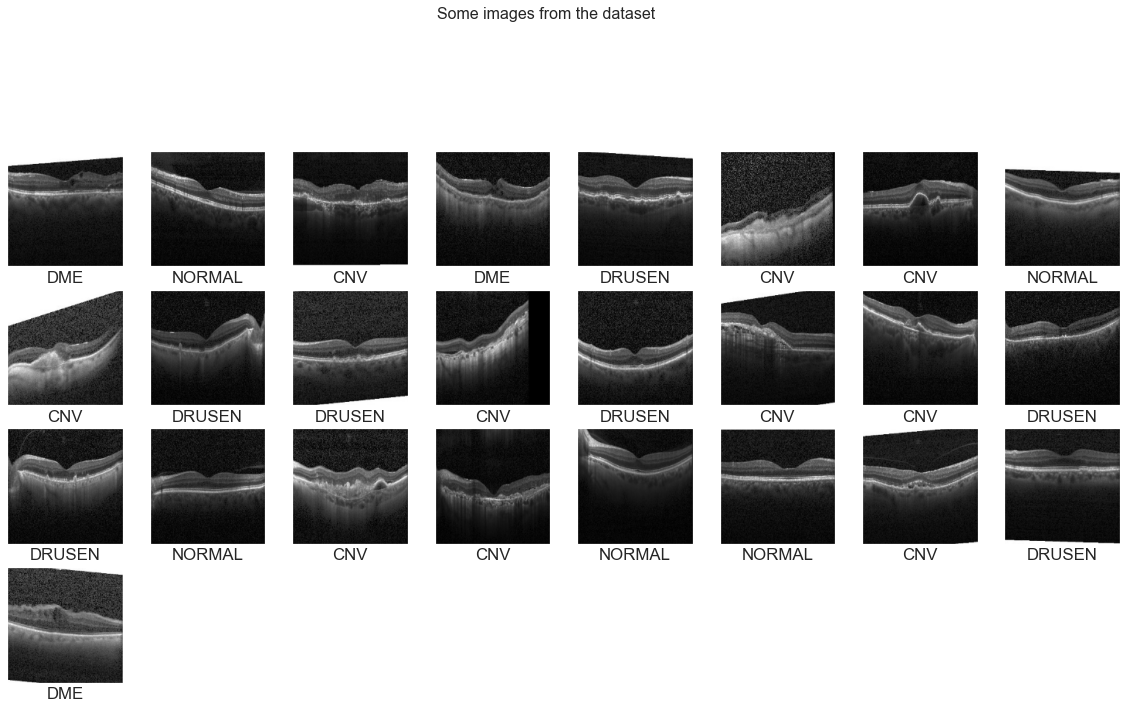

In [11]:
def display_examples(class_names,images,labels):
    
    figsize=(20,20)
    fig= plt.figure(figsize=figsize)
    fig.suptitle("Some images from the dataset",fontsize=16)
    
    for i in range(25):
        plt.subplot(8,8,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        
        plt.imshow(images[i].astype(np.uint8))
        plt.xlabel(class_names[labels[i]])
        
    plt.show()
display_examples(class_names,train_images,train_labels)

### DATA CLEANING

In [12]:
def clean_dataset(input_directory):
    cleaned_images = []
    cleaned_labels = []

    for root, _, files in os.walk(input_directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                img = cv2.imread(file_path)
                if img is not None:
                    # Image is readable, add it to the cleaned dataset
                    cleaned_images.append(file_path)
                    cleaned_labels.append(root.split(os.path.sep)[-1])
                    
                    # Save the cleaned image to the input directory
                    cv2.imwrite(file_path, img)
                else:
                    # Image is corrupted
                    print(f"Warning: Corrupted image found at {file_path}. Skipping.")

    return cleaned_images, cleaned_labels

input_directory = r"C:\dataset"

cleaned_images, cleaned_labels = clean_dataset(input_directory)

print(f"Number of cleaned images: {len(cleaned_images)}")
print(f"Number of cleaned labels: {len(cleaned_labels)}")


Number of cleaned images: 15611
Number of cleaned labels: 15611


### DATA PREPROCESSING

#### Image Resizing

In [13]:
def resize_images(images, size):
    resized_images = []
    for img_path in images:
        img = cv2.imread(img_path)
        resized_img = cv2.resize(img, size)
        resized_images.append(resized_img)
    return resized_images

target_size = (150, 150)

resized_images = resize_images(cleaned_images, target_size)

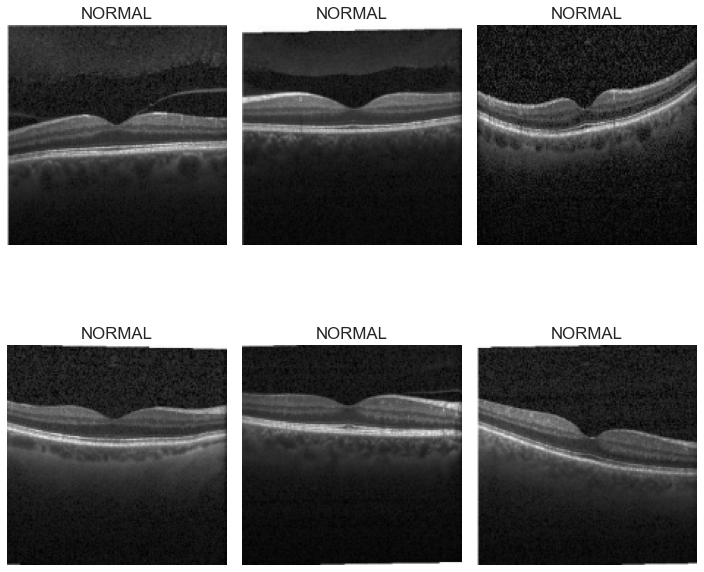

In [14]:
def display_images_from_class(images, labels, class_name, nrows=2, ncols=3):
    
    class_indices = [i for i, label in enumerate(labels) if label == class_name]
    class_images = [images[i] for i in class_indices[:nrows*ncols]]
    class_labels = [labels[i] for i in class_indices[:nrows*ncols]]

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(class_images[i])
        ax.set_title(class_labels[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

display_images_from_class(resized_images, cleaned_labels, class_name='NORMAL')


#### Normalization

In [15]:
def normalize_images(images):
    images_array = np.array(images)
    normalized_images = images_array / 255.0
    
    return normalized_images

normalized_images = normalize_images(resized_images)

#### Data Augmentation

In [16]:
from keras.preprocessing.image import ImageDataGenerator

Found 15611 images belonging to 4 classes.


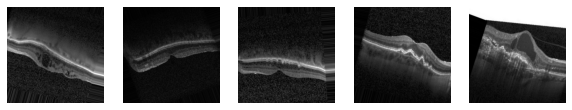

In [17]:
def augment_and_display_images(input_dir, augment_factor=5, num_images=5):
    
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    data_generator = datagen.flow_from_directory(
        input_dir,  # Input directory containing original images
        target_size=(224, 224),  # Target size for the images
        batch_size=1,  # Batch size
        class_mode=None,  # Since we're not using labels, set to None
        shuffle=True  # Shuffle the data
    )

 
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        augmented_image = next(data_generator)[0].astype(np.uint8)  # Get the next augmented image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(augmented_image)
        plt.axis('off')
    plt.show()


input_directory = r"C:\dataset"
augment_and_display_images(input_directory, augment_factor=5, num_images=5)


### DATA BALANCING

In [18]:
def count_images_per_class(dataset_directory, class_names):
    class_counts = {}
    for class_name in class_names:
        class_directory = os.path.join(dataset_directory, class_name)
        num_images = len(os.listdir(class_directory))
        class_counts[class_name] = num_images
    return class_counts

dataset_directory = r"C:\dataset\train"
class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
class_counts = count_images_per_class(dataset_directory, class_names)
print(class_counts)


{'CNV': 4033, 'DME': 2582, 'DRUSEN': 4438, 'NORMAL': 3558}


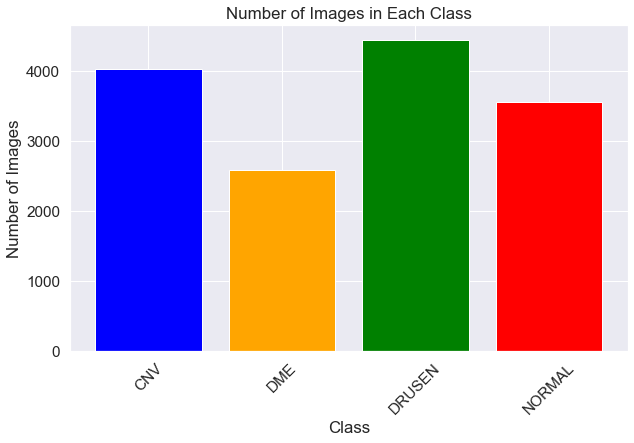

In [19]:
plt.figure(figsize=(10, 6))
colors = ['blue', 'orange', 'green', 'red']
plt.bar(class_counts.keys(), class_counts.values(), color=colors)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.xticks(rotation=45)
plt.show()


In [20]:
from sklearn.utils import resample

dataset_directory = r"C:\dataset\train"

class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

#max images among all classes
max_samples = max([len(os.listdir(os.path.join(dataset_directory, class_name))) for class_name in class_names])

balanced_images = []
balanced_labels = []
for class_name in class_names:
    class_directory = os.path.join(dataset_directory, class_name)
    class_images = [os.path.join(class_directory, file) for file in os.listdir(class_directory)]
    sampled_images = resample(class_images, n_samples=max_samples, replace=True, random_state=42)
    balanced_images.extend(sampled_images)
    balanced_labels.extend([class_names.index(class_name)] * max_samples)

balanced_images = np.array(balanced_images)
balanced_labels = np.array(balanced_labels)

shuffle_indices = np.arange(len(balanced_images))
np.random.shuffle(shuffle_indices)
balanced_images = balanced_images[shuffle_indices]
balanced_labels = balanced_labels[shuffle_indices]


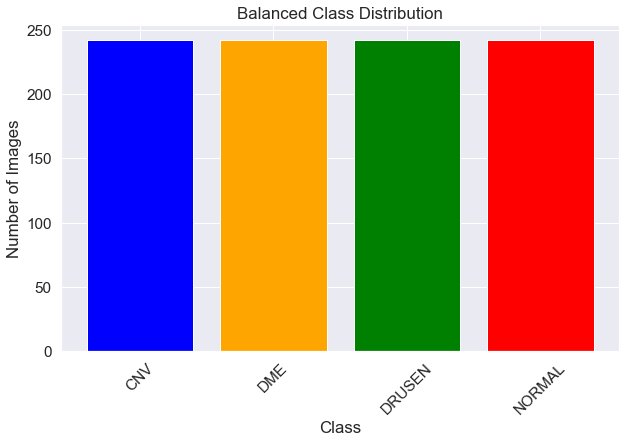

In [21]:
import os
import matplotlib.pyplot as plt

# Define the dataset directory and class names
dataset_directory = r"C:\dataset\test"
class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

# Define colors for each class
class_colors = {'CNV': 'blue', 'DME': 'orange', 'DRUSEN': 'green', 'NORMAL': 'red'}

# Create a dictionary to store class counts
balanced_class_counts = {}
# Calculate the balanced class distribution
for class_name in class_names:
    class_directory = os.path.join(dataset_directory, class_name)
    # Replace the logic below with your method of balancing classes
    num_images = len(os.listdir(class_directory))
    balanced_class_counts[class_name] = num_images

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(balanced_class_counts.keys(), balanced_class_counts.values(), color=[class_colors[class_name] for class_name in balanced_class_counts.keys()])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Balanced Class Distribution')
plt.xticks(rotation=45)
plt.show()


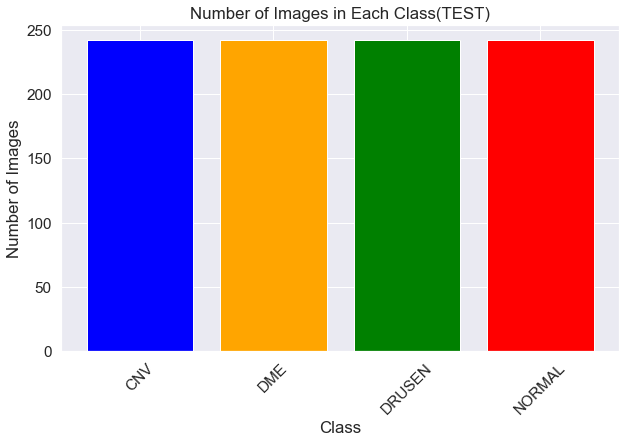

In [22]:
dataset_directory = r"C:\dataset\test"

class_names = ['CNV','DME','DRUSEN','NORMAL']

colors = ['blue', 'orange', 'green', 'red']
class_counts = {}
for class_name, color in zip(class_names, colors):
    class_directory = os.path.join(dataset_directory, class_name)
    num_images = len(os.listdir(class_directory))
    class_counts[class_name] = num_images

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color=colors)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class(TEST)')
plt.xticks(rotation=45)
plt.show()


In [23]:
from keras.layers import MaxPooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization

In [24]:
def cnn(filter1, filter2, filter3, hidden1):
    model = Sequential([
        tf.keras.layers.InputLayer(input_shape=(150, 150, 3)),
        # Add convolutional layers
        conv_layer(filter1),
        conv_layer(filter2),
        conv_layer(filter3),
        # Flatten layer
        tf.keras.layers.Flatten(),
        # Dense layer
        dens_layer(hidden1),
        # Output layer with 4 classes
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

In [25]:
def conv_layer(filterx):
    model = Sequential()
    model.add(tf.keras.layers.Conv2D(filterx, (4, 4), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    return model

def dens_layer(hiddenx):
    model = Sequential()
    model.add(tf.keras.layers.Dense(hiddenx, kernel_regularizer='l2'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LeakyReLU())
    return model


In [26]:
X_valid, y_valid = train_images[-10000:], train_labels[-10000:]
X_train, y_train = train_images[:-10000], train_labels[:-10000]

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [31]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
train_labels_one_hot = to_categorical(train_labels)
test_labels_one_hot = to_categorical(test_labels)
y_valid_one_hot = to_categorical(y_valid)

# Define model parameters
filter1 = 32
filter2 = 64
filter3 = 128
hidden1 = 256
num_epochs = 20

num_train_samples = 3000
num_val_samples = 900

# Select subsets for training and validation
train_images_subset = train_images[:num_train_samples]
train_labels_subset = train_labels_one_hot[:num_train_samples]

X_valid_subset = X_valid[:num_val_samples]
y_valid_subset = y_valid_one_hot[:num_val_samples]

# Create and compile the model
model = cnn(filter1, filter2, filter3, hidden1)

# Train the model on the subset
model.fit(train_images_subset, train_labels_subset, epochs=num_epochs, validation_data=(X_valid_subset, y_valid_subset))

# Evaluate the model on the full test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels_one_hot)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Train on 3000 samples, validate on 900 samples
Epoch 1/20
3000/3000 [==============================] - ETA: 0s - loss: 4.4626 - accuracy: 0.4320

C:\Users\sihus\anaconda3\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


3000/3000 [==============================] - 450s 150ms/sample - loss: 4.4626 - accuracy: 0.4320 - val_loss: 2.0979 - val_accuracy: 0.5000
Epoch 2/20
3000/3000 [==============================] - 431s 144ms/sample - loss: 1.7671 - accuracy: 0.5590 - val_loss: 2.8160 - val_accuracy: 0.2722
Epoch 3/20
3000/3000 [==============================] - 410s 137ms/sample - loss: 1.5316 - accuracy: 0.6043 - val_loss: 1.4773 - val_accuracy: 0.5400
Epoch 4/20
3000/3000 [==============================] - 421s 140ms/sample - loss: 1.4369 - accuracy: 0.6377 - val_loss: 1.7111 - val_accuracy: 0.4833
Epoch 5/20
3000/3000 [==============================] - 429s 143ms/sample - loss: 1.3730 - accuracy: 0.6640 - val_loss: 1.6854 - val_accuracy: 0.5989
Epoch 6/20
3000/3000 [==============================] - 426s 142ms/sample - loss: 1.4386 - accuracy: 0.6703 - val_loss: 2.3912 - val_accuracy: 0.3567
Epoch 7/20
3000/3000 [==============================] - 416s 139ms/sample - loss: 1.2328 - accuracy: 0.7070 - v

In [40]:
model.save("cnn_model.h5")

In [28]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
train_labels_one_hot = to_categorical(train_labels)
test_labels_one_hot = to_categorical(test_labels)
y_valid_one_hot = to_categorical(y_valid)

# Define model parameters
filter1 = 32
filter2 = 64
filter3 = 128
hidden1 = 256
num_epochs = 20

num_train_samples = 3000
num_val_samples = 900

# Select subsets for training and validation
train_images_subset = train_images[:num_train_samples]
train_labels_subset = train_labels_one_hot[:num_train_samples]

X_valid_subset = X_valid[:num_val_samples]
y_valid_subset = y_valid_one_hot[:num_val_samples]

In [29]:
from tensorflow.keras.models import load_model

# Load the pre-trained model
model = load_model('cnn_model.h5')

# Train the model on the subset
model.fit(train_images_subset, train_labels_subset, epochs=30, validation_data=(X_valid_subset, y_valid_subset))

# Save the updated model
model.save('updated_model.h5')


Instructions for updating:
Colocations handled automatically by placer.
Train on 3000 samples, validate on 900 samples
Epoch 1/30
3000/3000 [==============================] - ETA: 0s - loss: 4.4046 - accuracy: 0.4403

C:\Users\sihus\anaconda3\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


3000/3000 [==============================] - 183s 61ms/sample - loss: 4.4046 - accuracy: 0.4403 - val_loss: 2.5388 - val_accuracy: 0.3033
Epoch 2/30
3000/3000 [==============================] - 185s 62ms/sample - loss: 1.7569 - accuracy: 0.5690 - val_loss: 1.8148 - val_accuracy: 0.4333
Epoch 3/30
3000/3000 [==============================] - 170s 57ms/sample - loss: 1.5070 - accuracy: 0.6087 - val_loss: 2.6788 - val_accuracy: 0.2733
Epoch 4/30
3000/3000 [==============================] - 184s 61ms/sample - loss: 1.4270 - accuracy: 0.6480 - val_loss: 1.4692 - val_accuracy: 0.5833
Epoch 5/30
3000/3000 [==============================] - 171s 57ms/sample - loss: 1.3565 - accuracy: 0.6657 - val_loss: 2.0450 - val_accuracy: 0.4144
Epoch 6/30
3000/3000 [==============================] - 170s 57ms/sample - loss: 1.3605 - accuracy: 0.6903 - val_loss: 2.2283 - val_accuracy: 0.3389
Epoch 7/30
3000/3000 [==============================] - 176s 59ms/sample - loss: 1.2438 - accuracy: 0.7043 - val_loss

In [32]:
# Evaluate the model on the full test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels_one_hot)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Retrieve final training accuracy and validation accuracy directly from the model
final_train_accuracy = model.history.history['accuracy'][-1]
final_val_accuracy = model.history.history['val_accuracy'][-1]

print("Final Training Accuracy:", final_train_accuracy)
print("Final Validation Accuracy:", final_val_accuracy)


Test Loss: 1.2954578650884392
Test Accuracy: 0.70247936
Final Training Accuracy: 0.8893333077430725
Final Validation Accuracy: 0.5766666531562805


Text(0, 0.5, 'Losses')

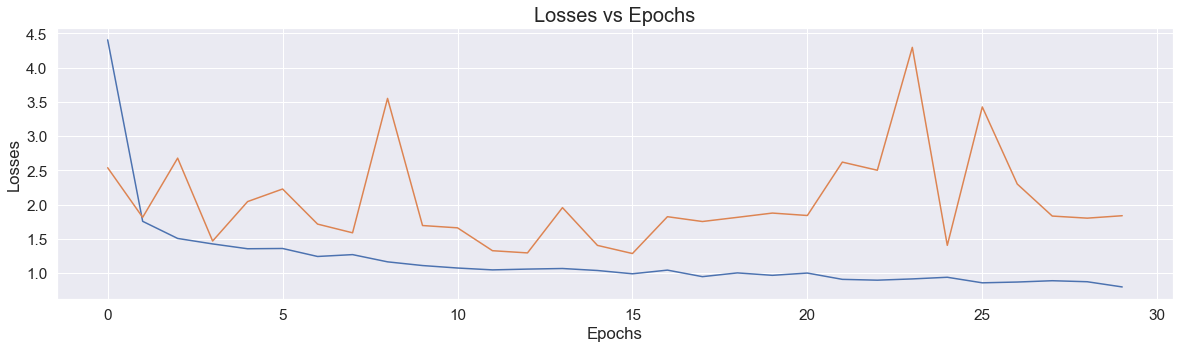

In [35]:
plt.figure(figsize = (20,5))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Losses vs Epochs', fontsize = 20)
plt.xlabel('Epochs')
plt.ylabel('Losses')

Text(0, 0.5, 'Accuracy')

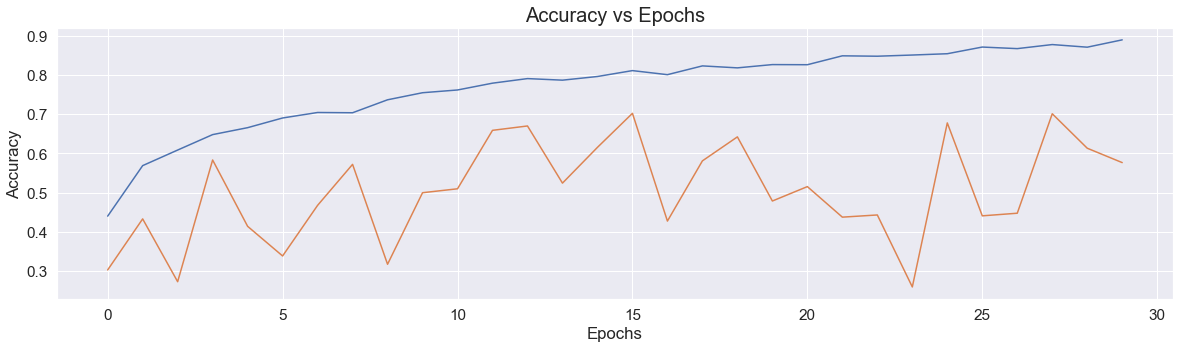

In [36]:
plt.figure(figsize = (20,5))
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Accuracy vs Epochs', fontsize = 20)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

C:\Users\sihus\anaconda3\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


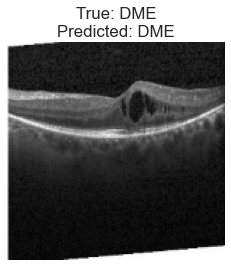

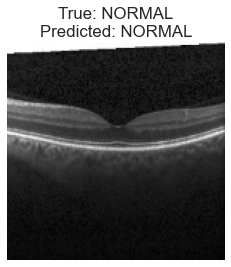

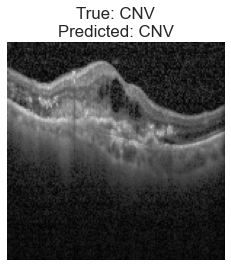

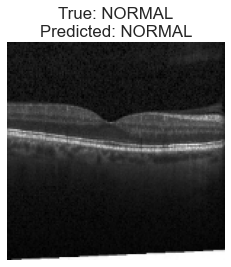

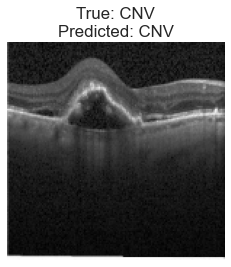

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def get_class_name(label):
    class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL'] 
    return class_names[label]

# Randomly select a few images from the test set
num_images = 5  # Number of images to visualize
indices = np.random.randint(0, len(test_images), num_images)

# Visualize the images and their predictions
for idx in indices:
    image = test_images[idx]
    label = test_labels[idx]
    
    # Make predictions on the image
    prediction = model.predict(np.expand_dims(image, axis=0))
    predicted_label = np.argmax(prediction)
    
    # Convert labels to class names
    true_class = get_class_name(label)
    predicted_class = get_class_name(predicted_label)
    
    # Plot the image with its true and predicted labels
    normalized_image= image/255.0
    plt.imshow(normalized_image)
    plt.title(f'True: {true_class}\nPredicted: {predicted_class}')
    plt.axis('off')
    plt.show()
